# IMAGE REGISTRATION

### TO do
1. I might have to blur the images as preprocess
2. measure MSE only between central part of images to avoid black artifact at the edges
3. what are the range for the parameters of the affine transformation?
4. I might need to remove the average pool layer from the resnet to keep spatial information
5. Use dataloader
6. Use fast.ai

### IMPORT NECESSARY MODULES

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import skimage.io
from PIL import Image
import glob
from torchvision import transforms, utils
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt
from typing import Union, Callable, Optional, List, Tuple

In [3]:
def show_batch(images: torch.Tensor,
               n_col: int = 4,
               n_padding: int = 10,
               title: Optional[str] = None,
               pad_value: int = 1):
    """Visualize a torch tensor of shape: (batch x ch x width x height) """
    assert len(images.shape) == 4  # batch, ch, width, height
    if images.device != "cpu":
        images = images.cpu()
    grid = utils.make_grid(images, n_col, n_padding, normalize=True, range=(0.0, 1.0),
                           scale_each=False, pad_value=pad_value)
        
    fig = plt.figure()
    plt.imshow(grid.detach().numpy().transpose((1, 2, 0)))
    if isinstance(title, str):
        plt.title(title)
    plt.close(fig)
    fig.tight_layout()
    return fig

def make_batch_from_list_PIL(list_pil, augmentation):
    imgs_in = None
    for tmp in list_pil:
        tmp_tensor = augmentation(tmp).unsqueeze(0)
        try:
            imgs_in = torch.cat((imgs_in,tmp_tensor), dim=0)
        except TypeError:
            imgs_in = tmp_tensor
    return imgs_in

def make_edge_mask(dimensions, edge_size: int):
    m = torch.ones(small_dimensions)
    m[:,:edge_size] = 0
    m[:,-edge_size:] = 0
    m[:edge_size,:] = 0
    m[-edge_size:,:] = 0
    return m[None,None,...]

# PREPROCESSING

1. Convert PDF to PNG
2. Open as PIL in grayscale (b/c scanner might be grayscale) 
3. Save as a target_batch

### from PDF to PILS

In [ ]:
# target
!pdftoppm empty_form_color.pdf empty_form_color -png  # convert pdf to png
target_pil = Image.open("./empty_form_color-1.png")  # open as PIL

# examples
!pdftoppm sample_input.pdf sample_input -png  # convert pdf to png
list_pngs = glob.glob("./sample_input*.png")
list_pil = []
for file in list_pngs:
    tmp_image = Image.open(file)
    list_pil.append(tmp_image)

In [4]:
# Define the preprocessing "pipeline"
raw_dimensions = (1651, 1275)  # aspect ration 1.2949
small_dimensions = (290, 224)  # aspect ration 1.2949

no_preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

resize_preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(small_dimensions),  # short edge will be this size
    transforms.ToTensor()
])

resize_augment_preproces = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(small_dimensions),  # short edge will be this size
    #transforms.Pad(min(small_dimensions)//2, fill=(255,255,255), padding_mode='constant'),# 
    transforms.Pad(min(small_dimensions)//2, fill=(0,0,0), padding_mode='constant'),# 
    #transforms.Pad(min(small_dimensions)//2, padding_mode='edge'),# 
    transforms.RandomAffine(degrees=5, translate=(0.05,0.05), scale=None, shear=None, resample=False, fillcolor=0),
    transforms.CenterCrop(small_dimensions),  
    transforms.ToTensor()
])

### Make tensors

In [16]:
target = preprocess_target(target_pil).unsqueeze(0) # create a mini-batch as expected by the model
target_raw = no_preprocess(target_pil).unsqueeze(0) # create a mini-batch as expected by the model
imgs_in = make_batch_from_list_PIL(list_pil=list_pil, augmentation=augmentation)

### Visualize

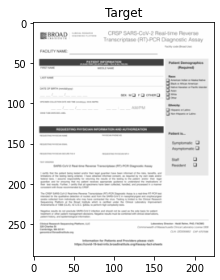

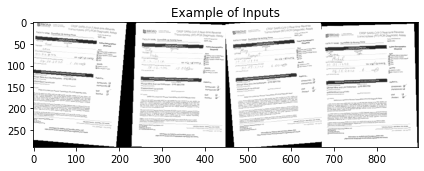

In [17]:
a = show_batch(target, n_padding=0, title="Target")
b = show_batch(imgs_in, n_padding=0, title="Example of Inputs")
display(a,b)

# RESNET FOR REGRESSING AFFINE TRANSFORMATION

In [14]:
class Identity(torch.nn.Module):

    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x
    
#register_forward_hook(hook)[SOURCE]
#Registers a forward hook on the module.
#The hook will be called every time after forward() has computed an output. It should have the following signature:
#printing_hook(module, x, x):

def apply_registration(input_imgs, affine, weight, bias, target):
    x1 = input_imgs * weight[..., None, None] + bias[..., None, None]
    grid = F.affine_grid(affine, list(target.shape), align_corners=False)
    x2 = F.grid_sample(x1, grid, mode='bilinear', padding_mode='border')
    return x2
    
def print_hook_pre(module, input):
    if isinstance(input,tuple):
        for x in input:
            print("pre_A ->",x.shape)
    else:
        print("pre_B ->",input.shape)

def print_hook_post(module,input,output):
    if isinstance(input,tuple):
        for x in input:
            print("post_C ->",x.shape)
    else:
        print("post_D ->",input.shape)
    
class RegisterImg(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet18', pretrained=True)
        
        self.resnet.avgpool.register_forward_hook(print_hook_post)
        self.resnet.layer4[1].conv2.register_forward_hook(print_hook_post)
        self.resnet.layer2[1].conv2.register_forward_hook(print_hook_post)
        self.resnet.avgpool.register_forward_pre_hook(print_hook_pre)
        self.resnet.avgpool.register_forward_hook(print_hook_post)
        self.resnet.fc.register_forward_pre_hook(print_hook_pre)
        self.resnet.fc.register_forward_hook(print_hook_post)
        #for name, module in self.resnet.modules():
        #    module.register_forward_hook(self,print_hook_fn)
            
        #register_forward_hook(hook)
        
        #for param in self.resnet.parameters():
        #    param.requires_grad = False
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = torch.nn.Linear(num_ftrs, 6)
        
        #self.resnet.avgpool = Identity()
        #self.resnet.fc = Identity()
        
    def forward(self, imgs_in):
        x1 = self.resnet(imgs_in)
        affine, weight, bias = torch.split(x1, (6,3,3), dim=-1)
        return affine.view(-1,2,3), weight, bias
    

net = RegisterImg()
#net

Using cache found in /Users/ldalessi/.cache/torch/hub/pytorch_vision_v0.5.0


## Training loop

In [15]:
optimizer = torch.optim.Adam(net.parameters(), 
                             lr=0.001,
                             betas = [0.9, 0.999],
                             weight_decay = 1.0,
                             eps = 1E-8)

loss_history = []
net.train()
criterion = torch.nn.MSELoss()
edge_mask = make_edge_mask(small_dimensions, edge_size=20)
for epoch in range(1000):
    
    imgs_in = make_batch_from_list_PIL(list_pil=list_pil, augmentation=augmentation)
    batch_size = imgs_in.shape[0]
    target_batch = target_tensor.expand(batch_size,-1,-1,-1)

    optimizer.zero_grad()
    affine, weight, bias = resnet(imgs_in)
    imgs_out = apply_registration(imgs_in, affine, weight, bias, target_batch)
    loss = criterion(imgs_out*edge_mask, target_batch*edge_mask)
    loss.backward()  
    optimizer.step()  
    
    loss_history.append(loss.item())
    print(epoch, loss_history[-1])

post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
0 0.07472948729991913
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
1 0.06914444267749786
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
2 0.07033868134021759
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
3 0.05640802159905434
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10,

35 0.28132104873657227
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
36 0.24138085544109344
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
37 0.06631159037351608
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
38 0.15492457151412964
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
39 0.036957718431949615
post_C -> torch.Size([4, 128, 37, 28])
post_

71 0.1295793354511261
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
72 0.048939049243927
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
73 0.030542979016900063
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
74 0.024410616606473923
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
75 0.02938206121325493
post_C -> torch.Size([4, 128, 37, 28])
post_C 

107 0.027198385447263718
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
108 0.026250874623656273
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
109 0.030861888080835342
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
110 0.03204120323061943
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
111 0.026576366275548935
post_C -> torch.Size([4, 128, 37, 28

142 0.025292882695794106
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
143 0.06720678508281708
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
144 0.02808312140405178
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
145 0.028228500857949257
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
146 0.03448646515607834
post_C -> torch.Size([4, 128, 37, 28])

177 0.04466003179550171
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
178 0.026719052344560623
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
179 0.025316644459962845
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
180 0.02566332370042801
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
181 0.030649513006210327
post_C -> torch.Size([4, 128, 37, 28]

212 0.024795837700366974
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
213 0.03021601028740406
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
214 0.0259089395403862
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
215 0.025884464383125305
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
216 0.08200408518314362
post_C -> torch.Size([4, 128, 37, 28])


247 0.024852648377418518
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
248 0.025125496089458466
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
249 0.03164518624544144
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
250 0.02503274194896221
post_C -> torch.Size([4, 128, 37, 28])
post_C -> torch.Size([4, 512, 10, 7])
pre_A -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
post_C -> torch.Size([4, 512, 10, 7])
torch.Size([4, 12])
251 0.02570401132106781
post_C -> torch.Size([4, 128, 37, 28])

KeyboardInterrupt: 

# evaluation

In [ ]:
plt.plot(loss_history)

In [ ]:
net.eval()
output = net(imgs_in, target_dims = [imgs_in.shape[0]] + list(target.shape[-3:]))

In [ ]:
show_batch(output)